In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [148]:
import rdata
frequency = rdata.read_rda("data//fremotor1freq0304a.rda")
premium = rdata.read_rda("data//fremotor1prem0304a.rda")
severity = rdata.read_rda("data//fremotor1sev0304a.rda")
freq_df = frequency["fremotor1freq0304a"]
prem_df = premium["fremotor1prem0304a"]
sev_df = severity["fremotor1sev0304a"]
sev_df["OccurDate"] = pd.to_datetime(sev_df["OccurDate"], unit="D", origin="unix")
sev_df["OccurYear"] = sev_df["OccurDate"].dt.year
prem_df["Year"] = prem_df["Year"].astype(int)
prem_df["PremNonM"] = prem_df["PremTot"] - prem_df["PremTPLM"]

/opt/conda/lib/python3.12/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "Date". The underlying R object is returned instead.
  warnings.warn(


In [151]:
def calc_inc_prec(row):
    if pd.isna(row["Renew"]):
        return pd.NA
    if row["Renew"]:
        return row["NextPremTot"]/row["PremTot"]-1.0
    return pd.NA

def calc_inc_amt(row):
    if pd.isna(row["Renew"]):
        return pd.NA
    if row["Renew"]:
        return row["NextPremTot"]-row["PremTot"]
    return pd.NA

prem_df_sorted = prem_df.sort_values(["IDpol","Year"],axis=0)
prem_df_sorted["NextIDpol"] = prem_df_sorted["IDpol"].shift(-1)
prem_df_sorted["NextPremTot"] = prem_df_sorted["PremTot"].shift(-1)
prem_df_sorted["NextPremNonM"] = prem_df_sorted["PremNonM"].shift(-1)
prem_df_sorted["Renew"] = prem_df_sorted["IDpol"] == prem_df_sorted["NextIDpol"]
prem_df_sorted["Downgrade"] = prem_df_sorted["NextPremNonM"] <= prem_df_sorted["PremNonM"]

In [152]:
prem_df_sorted["Increase_perc"] = prem_df_sorted.apply(calc_inc_prec,axis=1)
prem_df_sorted["Increase_amt"] = prem_df_sorted.apply(calc_inc_amt,axis=1)

In [153]:
mask = sev_df["OccurYear"] == 2003
clms_df = sev_df.loc[mask].pivot_table(index="IDpol",values="Payment",aggfunc="sum").reset_index()

In [154]:
mask = prem_df_sorted["Year"] == 2003
data_set = prem_df_sorted.loc[mask].copy()
data_set = pd.merge(data_set, clms_df,how="left")
data_set["LR"] = data_set["Payment"]/data_set["PremTot"]
data_set["LR"] = data_set["LR"].fillna(0)

def impute_increase(row):
    if not row["Renew"]:
        increase = row["LR"]/0.4-1
        if increase < 0.04:
            return 0
        if increase > 1:
            return 1
        return increase
    if row["Increase_perc"] <= 0:
        return 0
    return row["Increase_perc"]

data_set["Increase_perc_impute"] = data_set.apply(impute_increase, axis=1)
data_set["Increase_amt_impute"] = data_set["Increase_perc_impute"]*data_set["PremTot"]

In [159]:
mask = data_set["Renew"]
data_set.loc[mask,:].groupby("Downgrade")["Increase_perc_impute"].describe()

,count,mean,std,min,25%,50%,75%,max
Downgrade,,,,,,,,
False,14981.0,0.099402,0.109087,0.0,0.088225,0.090316,0.092112,2.952597
True,4848.0,0.003332,0.018609,0.0,0.000000,0.000000,0.000000,0.382801


In [132]:
mask = data_set["Renew"] == True
data_set.loc[mask, "Increase_perc"].describe()

count    19829.000000
mean         0.053273
std          0.134428
min         -0.762287
25%          0.003494
50%          0.089216
75%          0.091462
max          2.952597
Name: Increase_perc, dtype: float64

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = data_set.loc[:, ["DrivAge","Increase_perc_impute","PremTot","VehAge","BonusMalus","PremTPLM"]].values
y = data_set.loc[:,"Renew"]
#scaler = StandardScaler().fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [145]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6240211340692519

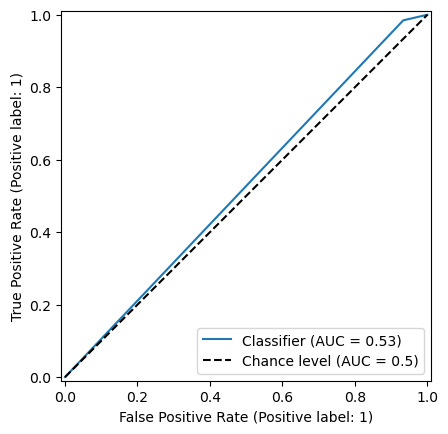

In [35]:
from sklearn import metrics
y_scores = clf.predict(X_test)
metrics.RocCurveDisplay.from_predictions(y_test, y_scores, plot_chance_level=True)

In [97]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores)
print("FPR",fpr)
print("TPR",tpr)
print("Thresholds",thresholds)

FPR [0.         0.93338342 1.        ]
TPR [0.         0.98455949 1.        ]
Thresholds [inf  1.  0.]


In [146]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.8420605717520521

[Text(0.5, 0.8333333333333334, 'x[1] <= 0.0\ngini = 0.474\nsamples = 21518\nvalue = [8295.0, 13223.0]'),
 Text(0.25, 0.5, 'x[2] <= 235.35\ngini = 0.419\nsamples = 11027\nvalue = [7738.0, 3289.0]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.335\nsamples = 1892\nvalue = [1490, 402]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.432\nsamples = 9135\nvalue = [6248, 2887]'),
 Text(0.75, 0.5, 'x[1] <= 0.633\ngini = 0.101\nsamples = 10491\nvalue = [557, 9934]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.018\nsamples = 9950\nvalue = [88, 9862]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.231\nsamples = 541\nvalue = [469, 72]')]

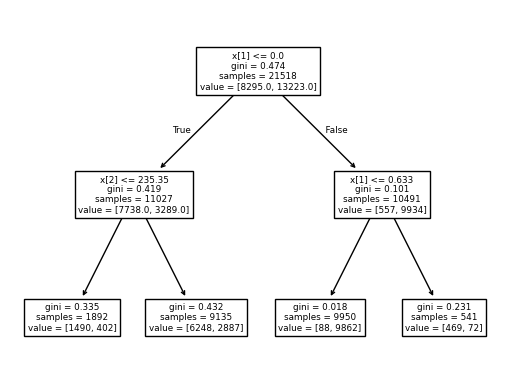

In [147]:
from sklearn.tree import plot_tree
plot_tree(clf_tree)

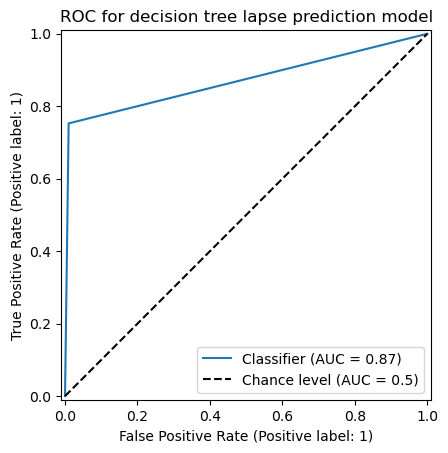

In [163]:
from sklearn import metrics
metrics.RocCurveDisplay.from_predictions(y_test, clf_tree.predict(X_test), plot_chance_level=True)
plt.title("ROC for decision tree lapse prediction model")
plt.show()

In [84]:
metrics.confusion_matrix(y_test, clf_tree.predict(X_test))

array([[3953,   40],
       [1634, 4972]])

In [ ]:
metrics.confusion_matrix(y_test, clf.predict(X_test))

array([[   0, 3993],
       [   0, 6606]])